# Bayesian Optimization with Gaussian Process

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Define Ground Truth Function

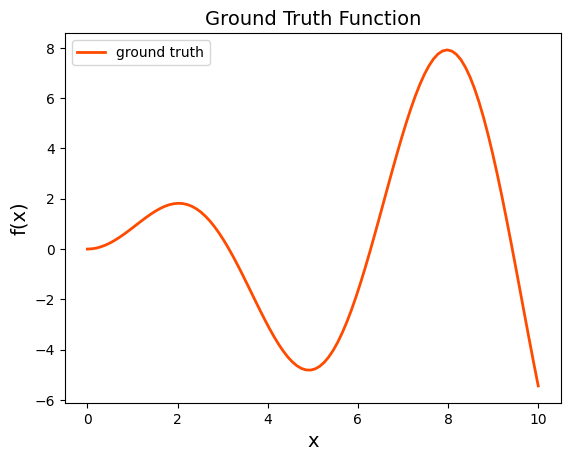

In [17]:
# define ground truth function
def ground_truth_func(x_array: np.ndarray) -> np.ndarray:
    return x_array * np.sin(x_array)

## settings
min_x, max_x = 0.0, +10.0
test_data_size = 100

## generate test data
X_test = np.linspace(min_x, max_x, test_data_size).reshape(-1, 1) # x is 1 dim
y_test = ground_truth_func(X_test)

## plot
plt.plot(X_test, y_test, color="#FF4B00", linewidth=2, zorder=1, label="ground truth") # orange line
plt.xlabel("x", fontsize=14) # x-axis label
plt.ylabel("f(x)", fontsize=14) # y-axis label
plt.title("Ground Truth Function", fontsize=14) # title
plt.legend()
plt.show()

## Define Gaussian Process Regressor

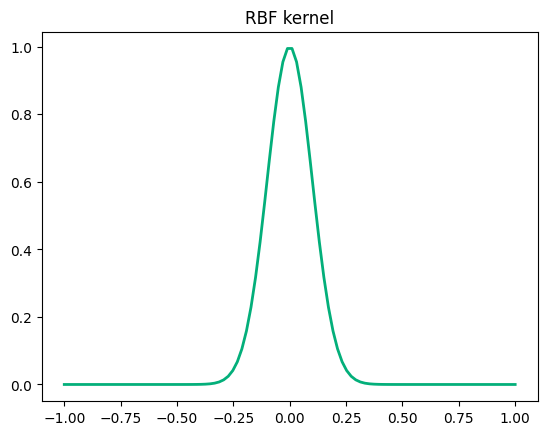

In [18]:
# gaussian process regressor
class GaussianProcessRegression:
    def __init__(self, kernel):
        self.kernel = kernel

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        # get matrix size
        train_data_size = X_train.shape[0]

        # calculate kernel matrix K (train_data_size x train_data_size)
        K = np.zeros((train_data_size, train_data_size))
        for r in range(train_data_size):
            for c in range(train_data_size):
                K[r, c] = self.kernel(X_train[r], X_train[c])

        # calculate expanded kernel matrix K_big (train_data_size x test_data_size)        
        K_big = np.zeros((train_data_size, test_data_size))
        for r in range(train_data_size):
            for c in range(test_data_size):
                K_big[r, c] = self.kernel(X_train[r], X_test[c])

        # calculate mean and variance
        s = self.kernel(X_test, X_test)
        yy = np.linalg.inv(K) @ y_train
        y_pred = K_big.T @ yy
        y_var = s - np.diag(K_big.T @ np.linalg.inv(K) @ K_big)

        # return prediction and variance of gaussian process
        return y_pred.reshape(-1, 1), y_var.reshape(-1, 1)

    def optimize(self):
        # TODO: optimize hyperparameters automatically
        pass

# define kernel function
def rbf_kernel(x_i: np.ndarray, x_j: np.ndarray) -> float:
    theta_1 = 1.0
    theta_2 = 2.0
    return theta_1 * np.exp(-1.0 * np.linalg.norm(x_i - x_j, ord=2) ** 2 / theta_2)

# plot kernel function
x = np.linspace(-1.0, 1.0, 100)
x_bar = np.zeros(x.shape)
y = [rbf_kernel(np.array([x_i]), np.array([x_bar])) for x_i in x]
plt.title("RBF kernel")
plt.plot(x, y, color="#03AF7A", linewidth=2)
plt.show()

# Execute Bayesian Optimization

Trial: 01, current optimal x*: 0.00, current optimal y = f(x*) = 0.00
Trial: 02, current optimal x*: 0.00, current optimal y = f(x*) = 0.00
Trial: 03, current optimal x*: 0.00, current optimal y = f(x*) = -0.00
Trial: 04, current optimal x*: 2.93, current optimal y = f(x*) = 0.62
Trial: 05, current optimal x*: 7.88, current optimal y = f(x*) = 7.94
Trial: 06, current optimal x*: 7.88, current optimal y = f(x*) = 7.98
Trial: 07, current optimal x*: 7.88, current optimal y = f(x*) = 7.97
Trial: 08, current optimal x*: 7.88, current optimal y = f(x*) = 7.98
Trial: 09, current optimal x*: 7.98, current optimal y = f(x*) = 7.92
Trial: 10, current optimal x*: 7.98, current optimal y = f(x*) = 7.92


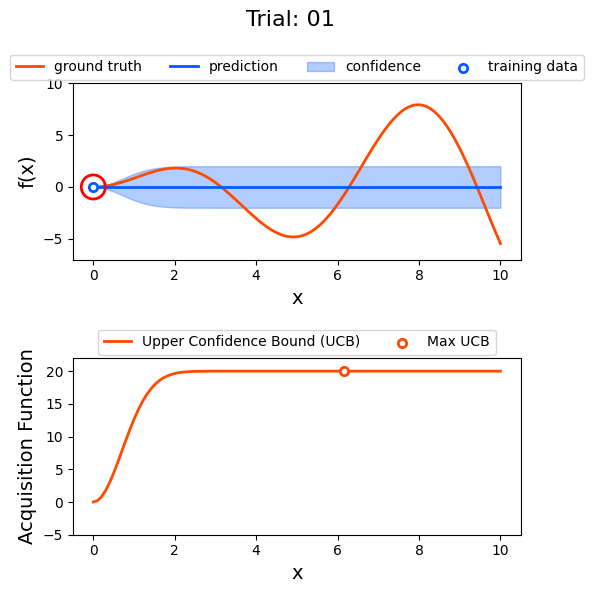

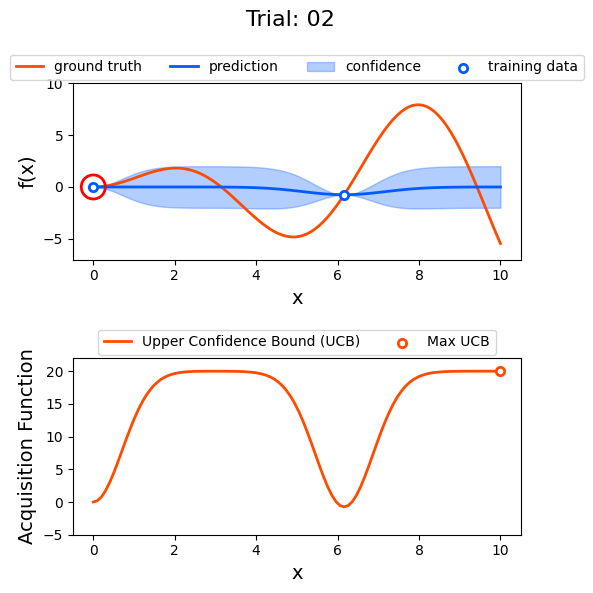

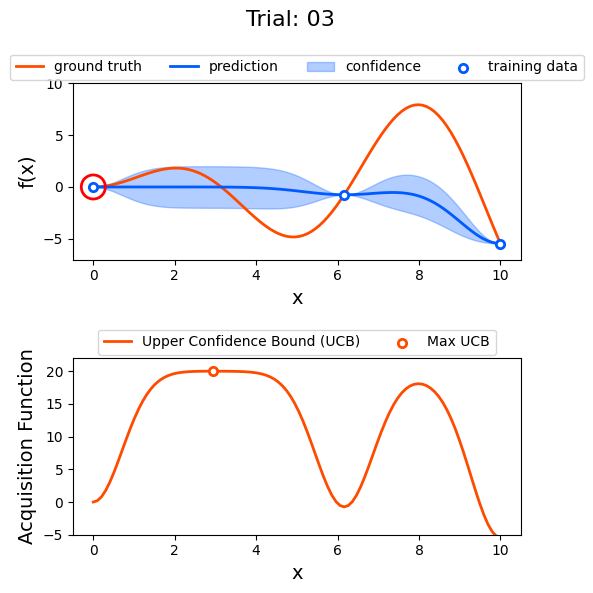

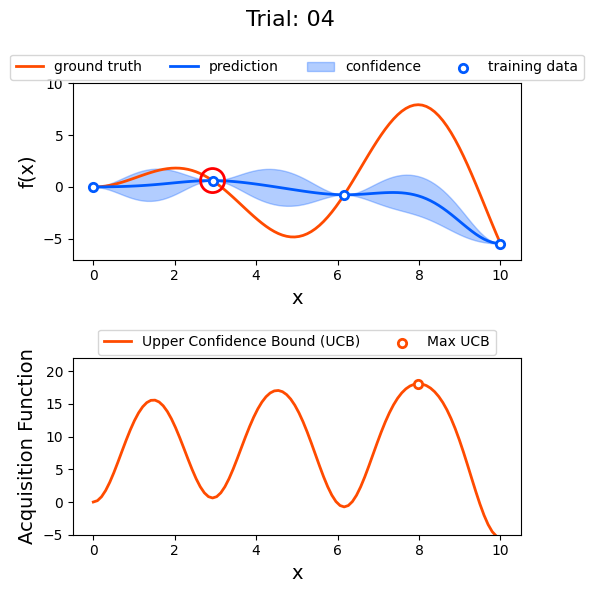

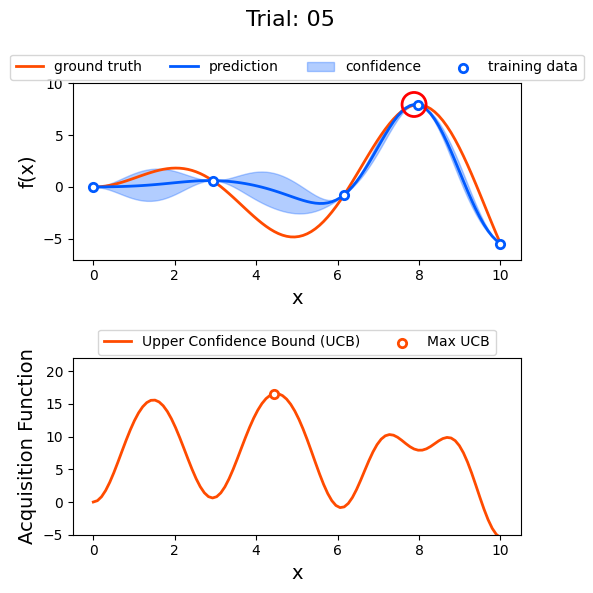

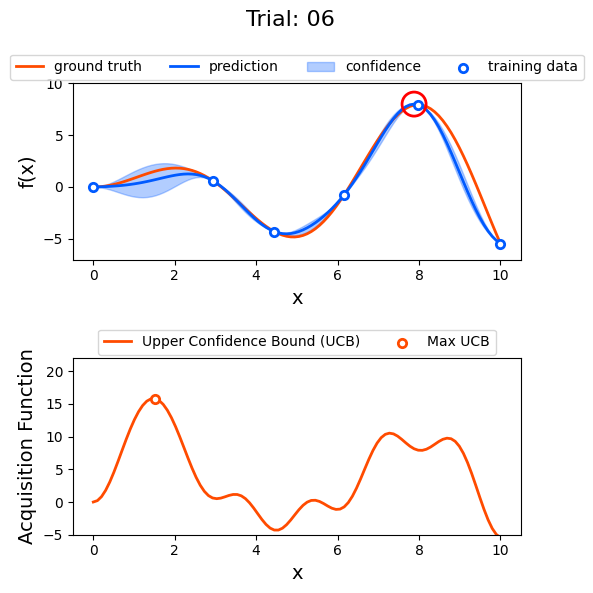

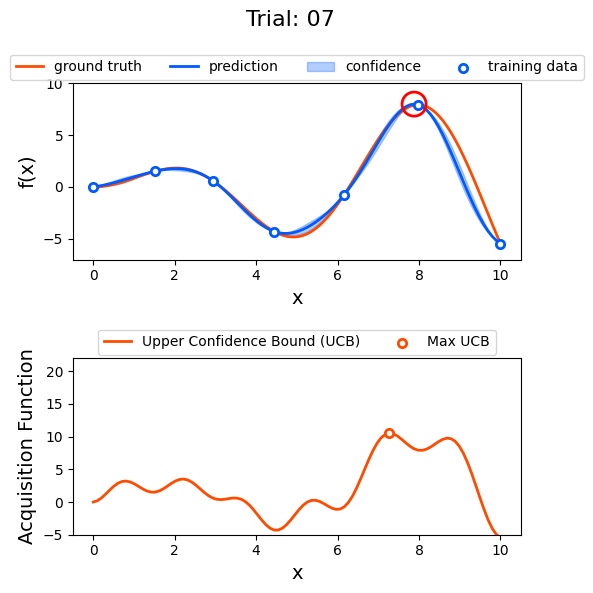

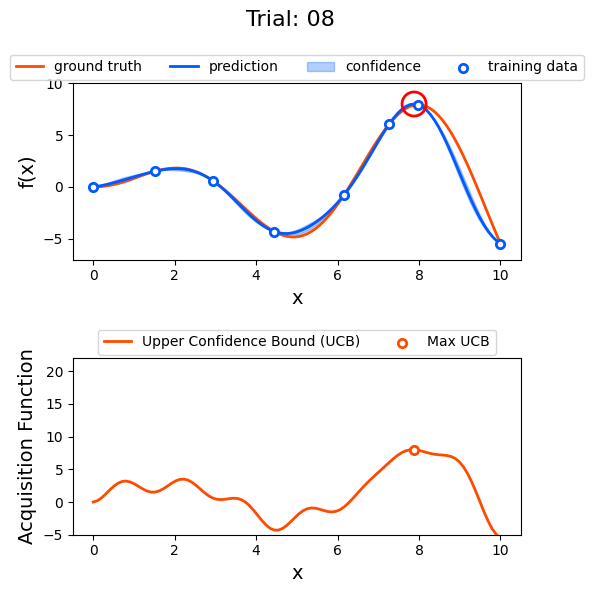

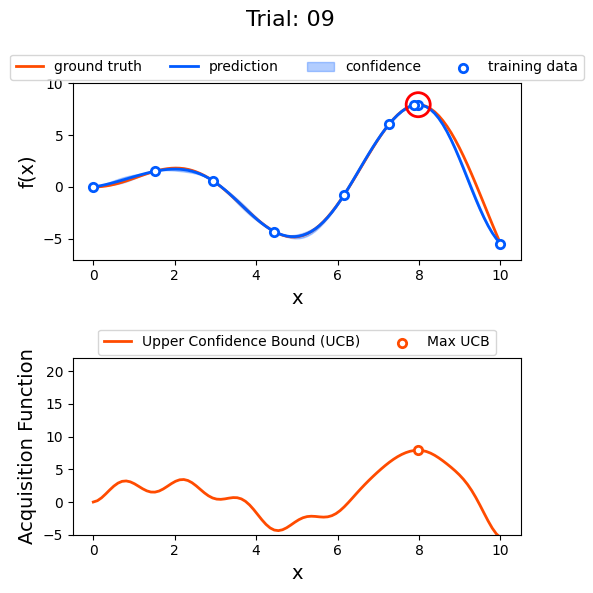

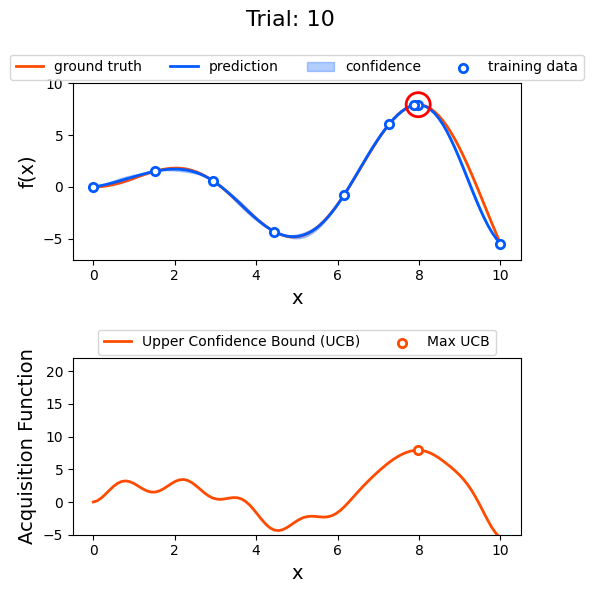

In [33]:
# settings
min_x, max_x = 0.0, +10.0
test_data_size = 100
initial_train_data_size = 0
num_total_trials = 10

# define acquisition function (upper confidence bound)
def UCB(mu: np.ndarray, sigma: np.ndarray, num_current_trial) -> np.ndarray:
    # [type 1] set k as constant
    k = 20.0
    # [type 2] set k as function of n
    # n = num_current_trial
    # k = np.sqrt(np.log(n) / n)
    return mu + k * sigma

# run bayesian optimization
## initialize training and test data
X_train = np.random.uniform(min_x, max_x, initial_train_data_size).reshape(-1, 1) # x is 1 dim
y_train = ground_truth_func(X_train)
X_test = np.linspace(min_x, max_x, test_data_size).reshape(-1, 1) # x is 1 dim
y_test = ground_truth_func(X_test)
gpr = GaussianProcessRegression(kernel=rbf_kernel)
y_pred, y_var = gpr.fit(X_train, y_train)

## repeat exploration process for num_total_trials times
for trial in range(1, num_total_trials+1):
    ucb = UCB(y_pred, y_var, trial)
    max_ucb_idx = np.argmax(ucb)

    x_next = X_test[max_ucb_idx]
    y_next = ground_truth_func(x_next)

    if x_next not in X_train:
        X_train = np.append(X_train, x_next).reshape(-1, 1)
        y_train = np.append(y_train, y_next).reshape(-1, 1)

    y_pred, y_var = gpr.fit(X_train, y_train)
    max_pred_idx = np.argmax(y_pred)
    print(f"Trial: {trial:02d}, current optimal x*: {X_test[max_pred_idx][0]:.2f}, current optimal y = f(x*) = {y_pred[max_pred_idx][0]:.2f}")

    # plot the result [y=f(x)]
    # plt.plot(X_test, y_test, color="#FF4B00", linewidth=2, zorder=1, label="ground truth") # orange line
    # plt.plot(X_test, y_pred, color="#005AFF", linewidth=2, zorder=2, label="prediction") # blue line
    # plt.fill_between(X_test[:,0], (y_pred - 2.0*y_var)[:,0], (y_pred + 2.0*y_var)[:,0], color="#005AFF", alpha=0.3, zorder=0, label="confidence") # blue area
    # plt.scatter(X_train, y_train, fc="white", ec="#005AFF", linewidth=2, zorder=3, label="training data") # blue points
    # plt.scatter(X_test[max_pred_idx], y_pred[max_pred_idx], fc="none", ec="#FF0000", s=300, linewidth=2, zorder=4) # red circle
    # plt.xlabel("x", fontsize=14) # x-axis label
    # plt.ylabel("f(x)", fontsize=14) # y-axis label
    # plt.title(f"Trial: {trial:02d}", fontsize=16) # title
    # plt.legend()
    # plt.show()
    # plt.savefig(f"{trial:02d}.png", dpi=300)

    # plot the result [y=f(x), UCB]
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    fig.suptitle(f"Trial: {trial:02d}", fontsize=16)
    ## upper plot
    ax[0].plot(X_test, y_test, color="#FF4B00", linewidth=2, zorder=1, label="ground truth") # orange line
    ax[0].plot(X_test, y_pred, color="#005AFF", linewidth=2, zorder=2, label="prediction") # blue line
    ax[0].fill_between(X_test[:,0], (y_pred - 2.0*y_var)[:,0], (y_pred + 2.0*y_var)[:,0], color="#005AFF", alpha=0.3, zorder=0, label="confidence") # blue area
    ax[0].scatter(X_train, y_train, fc="white", ec="#005AFF", linewidth=2, zorder=3, label="training data") # blue points
    ax[0].scatter(X_test[max_pred_idx], y_pred[max_pred_idx], fc="none", ec="#FF0000", s=300, linewidth=2, zorder=4) # red circle
    ax[0].set_xlabel("x", fontsize=14) # x-axis label
    ax[0].set_ylabel("f(x)", fontsize=14) # y-axis label
    ax[0].set_ylim([-7.0, 10.0]) # y-axis limit tuned manually
    ax[0].legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.20))
    ## lower plot
    ucb = UCB(y_pred, y_var, trial)
    max_ucb_idx = np.argmax(ucb)
    ax[1].plot(X_test, ucb, color="#FF4B00", linewidth=2, zorder=1, label="Upper Confidence Bound (UCB)") # orange line
    ax[1].scatter(X_test[max_ucb_idx], ucb[max_ucb_idx], fc="white", ec="#FF4B00", linewidth=2, zorder=3, label="Max UCB") # orange point
    ax[1].set_xlabel("x", fontsize=14) # x-axis label
    ax[1].set_ylabel("Acquisition Function", fontsize=14) # y-axis label
    ax[1].set_ylim([-5.0, 22.0]) # y-axis limit tuned manually
    ax[1].legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.20))
    ## adjust layout and save figure
    plt.tight_layout()
    plt.savefig(f"{trial:02d}.png", dpi=300)